In [1]:
#pip install hyperopt

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Reading in the data, preprocessing

In [3]:
df= pd.read_csv('archive/Employee Attrition.csv', index_col=0)
df = df.dropna(thresh=4)
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,dept,salary
Emp ID,,,,,,,,,
1.0,0.38,0.53,2.0,157.0,3.0,0.0,0.0,sales,low
2.0,0.80,0.86,5.0,262.0,6.0,0.0,0.0,sales,medium
3.0,0.11,0.88,7.0,272.0,4.0,0.0,0.0,sales,medium
4.0,0.72,0.87,5.0,223.0,5.0,0.0,0.0,sales,low
5.0,0.37,0.52,2.0,159.0,3.0,0.0,0.0,sales,low


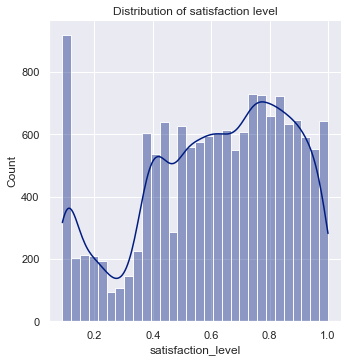

In [4]:
sns.set_theme(style="darkgrid", palette="dark")
sns.displot(df, x="satisfaction_level", alpha=.4, kde=True).set(title='Distribution of satisfaction level')

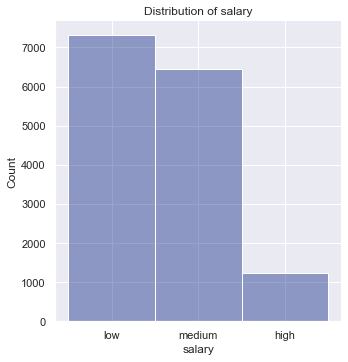

In [5]:
sns.displot(df, x="salary", alpha=.4).set(title='Distribution of salary')

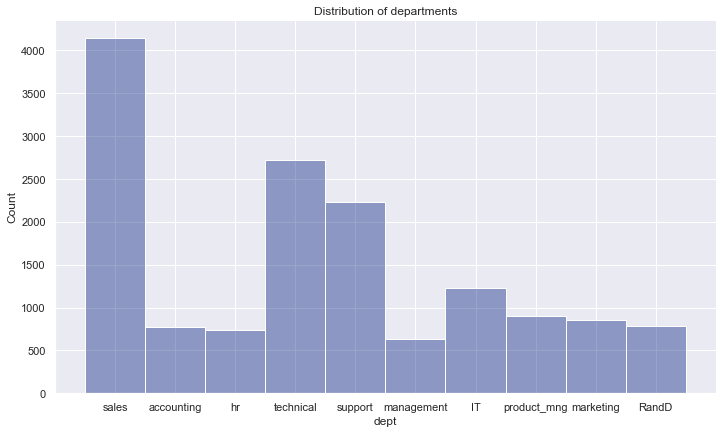

In [6]:
sns.displot(df, x="dept", alpha=.4, height=6, aspect=1.7).set(title='Distribution of departments')

In [7]:
encoded_df = pd.get_dummies(df, columns=['dept', 'salary'])

encoded_df = encoded_df.astype('float64')

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(encoded_df)

encoded_df = pd.DataFrame(scaled_data, columns=encoded_df.columns)

encoded_df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project           float64
average_montly_hours     float64
time_spend_company       float64
Work_accident            float64
promotion_last_5years    float64
dept_IT                  float64
dept_RandD               float64
dept_accounting          float64
dept_hr                  float64
dept_management          float64
dept_marketing           float64
dept_product_mng         float64
dept_sales               float64
dept_support             float64
dept_technical           float64
salary_high              float64
salary_low               float64
salary_medium            float64
dtype: object

## Baseline

In [9]:
X = encoded_df.drop('satisfaction_level', axis=1)
y = encoded_df['satisfaction_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Support Vector Regressor": SVR()
}

results = {}
residuals={}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = mse
    #y_cv_pred = cross_val_predict(model, X, y, cv=5)
    #residuals[name] = y - y_cv_pred
    residuals[name] = y_test - y_pred

for name, mse in results.items():
    print(f"{name}: MSE = {mse}")

baseline_model_name = min(results, key=results.get)
baseline_mse = results[baseline_model_name]

print(f"\nBaseline Model: {baseline_model_name} with MSE = {baseline_mse}")


Linear Regression: MSE = 0.06933325702840902
Decision Tree: MSE = 0.06557215832092204
Random Forest: MSE = 0.03736319652685439
Support Vector Regressor: MSE = 0.05027313125030986

Baseline Model: Random Forest with MSE = 0.03736319652685439


## Statistical tests

### Paired t-test

In [10]:
# Perform paired t-test between each pair of models - 
#   Checking whether there are statistically significant differences in the residuals (prediction errors) between the models, 
#   considering the variability introduced by cross-validation
#   Null hypothesis - the algorithms perform the same.
for i in range(len(models)):
    for j in range(i+1, len(models)):
        t_statistic, p_value = ttest_rel(residuals[list(models.keys())[i]], residuals[list(models.keys())[j]])
        print(f'Test between {list(models.keys())[i]} and {list(models.keys())[j]}:')
        print(f'    T-statistic: {t_statistic}, p-value: {p_value}')
        if p_value < 0.1:
            print('    Statistically significant difference. Algorithms perform differently.\n')
        else:
            print('    No statistically significant difference. Algorithms perform similarly.\n')

Test between Linear Regression and Decision Tree:
    T-statistic: 0.4132101837320959, p-value: 0.6794821695004579
    No statistically significant difference. Algorithms perform similarly.

Test between Linear Regression and Random Forest:
    T-statistic: -0.27777062136683567, p-value: 0.7812075915210075
    No statistically significant difference. Algorithms perform similarly.

Test between Linear Regression and Support Vector Regressor:
    T-statistic: 4.988526125752702, p-value: 6.430802595906725e-07
    Statistically significant difference. Algorithms perform differently.

Test between Decision Tree and Random Forest:
    T-statistic: -0.9623455959512107, p-value: 0.3359536173330788
    No statistically significant difference. Algorithms perform similarly.

Test between Decision Tree and Support Vector Regressor:
    T-statistic: 3.073179566453812, p-value: 0.0021369476762407645
    Statistically significant difference. Algorithms perform differently.

Test between Random Forest

### Wilcoxon signed-rank test

In [11]:
# Perform Wilcoxon signed-rank test between each pair of models based on residuals
# This test doesn't assume a normal distribution of the data and is less sensitive to extreme values, 
# which can be advantageous in some situations.
for i in range(len(models)):
    for j in range(i+1, len(models)):
        statistic, p_value = wilcoxon(residuals[list(models.keys())[i]], residuals[list(models.keys())[j]])
        print(f'Test between {list(models.keys())[i]} and {list(models.keys())[j]}:')
        print(f'Wilcoxon statistic: {statistic}, p-value: {p_value}')
        if p_value < 0.1:
            print('    Statistically significant difference.\n')
        else:
            print('    No statistically significant difference.\n')

Test between Linear Regression and Decision Tree:
Wilcoxon statistic: 2177680.0, p-value: 0.12354429773437796
    No statistically significant difference.

Test between Linear Regression and Random Forest:
Wilcoxon statistic: 2067916.0, p-value: 0.00011643374116373094
    Statistically significant difference.

Test between Linear Regression and Support Vector Regressor:
Wilcoxon statistic: 1782113.0, p-value: 5.223859041759612e-23
    Statistically significant difference.

Test between Decision Tree and Random Forest:
Wilcoxon statistic: 2162800.5, p-value: 0.06378569004025604
    Statistically significant difference.

Test between Decision Tree and Support Vector Regressor:
Wilcoxon statistic: 2184095.0, p-value: 0.16006303820774903
    No statistically significant difference.

Test between Random Forest and Support Vector Regressor:
Wilcoxon statistic: 2001509.0, p-value: 1.4952096800516338e-07
    Statistically significant difference.



## Analysis of Variance (ANOVA)

In [12]:
# Create a list of residuals for each model
residuals_list = [residuals[model_name] for model_name in models]

# Perform ANOVA on the residuals
statistic, p_value = f_oneway(*residuals_list)

print(f'ANOVA statistic: {statistic}, p-value: {p_value}')

if p_value < 0.1:
    print('At least one pair of models has a statistically significant difference.')
else:
    print('No statistically significant difference between models.')

ANOVA statistic: 2.8511135822576126, p-value: 0.035902123907397415
At least one pair of models has a statistically significant difference.


#### Post hoc test - Tukey's HSD test

In [13]:
# Flatten residuals and create corresponding model labels
all_residuals = [residual for residuals in residuals_list for residual in residuals]
model_labels = [model_name for model_name in models for _ in range(len(residuals_list[0]))]

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(np.concatenate(residuals_list), model_labels, alpha=0.1)

print(tukey_results)

               Multiple Comparison of Means - Tukey HSD, FWER=0.10               
      group1               group2          meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------
    Decision Tree        Linear Regression    0.002    0.9 -0.0119   0.016  False
    Decision Tree            Random Forest    0.003    0.9  -0.011  0.0169  False
    Decision Tree Support Vector Regressor  -0.0127 0.1598 -0.0266  0.0013  False
Linear Regression            Random Forest    0.001    0.9  -0.013  0.0149  False
Linear Regression Support Vector Regressor  -0.0147 0.0754 -0.0286 -0.0007   True
    Random Forest Support Vector Regressor  -0.0156   0.05 -0.0296 -0.0017   True
---------------------------------------------------------------------------------


## Trial

In [14]:
X = encoded_df.drop('satisfaction_level', axis=1)  # Features
y = encoded_df['satisfaction_level']               # Target

space = {
    'n_estimators': hp.choice('n_estimators', [5, 10, 25, 50, 100, 200, 250, 300, 350, 400]),
    'max_depth': hp.choice('max_depth', [3, 5, 10, 20, 25, 30, 40, None]),
    'min_samples_split': hp.choice('min_samples_split', [1, 2, 5, 7, 10, 15, 20, 30]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 5, 7, 10, 15, 20, 30]),
    'max_features': hp.choice('max_features', ['auto', 'sqrt']),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', [None, 3, 5, 10, 20, 30, 50, 100])
}

def objective(params):
    model = RandomForestRegressor(**params)
    score = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    return {'loss': score, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

best_params_converted = {
    'n_estimators': [5, 10, 25, 50, 100, 200, 250, 300, 350, 400][best_params['n_estimators']],
    'max_depth': [3, 5, 10, 20, 25, 30, 40, None][best_params['max_depth']],
    'min_samples_split': [1, 2, 5, 7, 10, 15, 20, 30][best_params['min_samples_split']],
    'min_samples_leaf': [1, 2, 5, 7, 10, 15, 20, 30][best_params['min_samples_leaf']],
    'max_features': ['auto', 'sqrt'][best_params['max_features']],
    'bootstrap': [True, False][best_params['bootstrap']],
    'max_leaf_nodes': [None, 3, 5, 10, 20, 30, 50, 100][best_params['max_leaf_nodes']]
}

best_model = RandomForestRegressor(**best_params_converted)
best_model.fit(X, y)

final_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
final_mse = -final_scores.mean()

print(f"Best Hyperparameters: {best_params_converted}")
print(f"Final Cross-Validated MSE: {final_mse}")


100%|█████████████████████████████████████████████| 100/100 [03:22<00:00,  2.03s/trial, best loss: 0.03916862644457951]
Best Hyperparameters: {'n_estimators': 350, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'max_leaf_nodes': None}
Final Cross-Validated MSE: 0.03916234627034196
